In [80]:
import pandas as pd

employee_survey = pd.read_csv('data/raw/employee_survey_data.csv')
employee_survey.head(1)

,EmployeeID,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,1,3.0,4.0,2.0


In [81]:
manager_survey = pd.read_csv('data/raw/manager_survey_data.csv')
manager_survey.head(1)

,EmployeeID,JobInvolvement,PerformanceRating
0,1,3,3


In [82]:
general_data = pd.read_csv('data/raw/general_data.csv')
general_data.head(1)


,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1.0,Y,11,8,0,1.0,6,1,0,0


In [83]:
import zipfile
import os

def get_in_out_time(DATA_DIR: str = 'data/raw') -> tuple[pd.DataFrame, pd.DataFrame]:
    join = os.path.join
    with zipfile.ZipFile(join(DATA_DIR,'in_out_time.zip'), 'r') as zip_ref:
        zip_ref.extractall(DATA_DIR)
    in_time = pd.read_csv(join(DATA_DIR,'in_time.csv'))
    out_time = pd.read_csv(join(DATA_DIR, 'out_time.csv'))

    # rename first column to 'EmployeeID'
    in_time.rename(columns={'Unnamed: 0': 'EmployeeID'}, inplace=True)
    out_time.rename(columns={'Unnamed: 0': 'EmployeeID'}, inplace=True)

    return in_time, out_time

in_time, out_time = get_in_out_time()
in_time.shape, out_time.shape

((4410, 262), (4410, 262))

In [84]:
def merge_times(in_t: pd.DataFrame, out_t: pd.DataFrame):
    # out_t and in_t have the same layout:
    #  - EmployeeID
    #  - 2015-01-01_x
    #  - 2015-01-02_x
    #  - ...

    # We want to merge them on EmployeeID and Date labels (labels are the same)
    columns = in_t.columns.to_list()

    in_out_times = pd.DataFrame(columns=columns)
    in_out_times['EmployeeID'] = in_t['EmployeeID']

    for c in columns[1:]:
        in_out_times[c] = (pd.to_datetime(out_t[c]) - pd.to_datetime(in_t[c])).round('5min').astype('timedelta64[m]')

    # transform all the deltas to median, avg and variance
    o = pd.DataFrame(columns=['EmployeeID', 'MedianWorkingTime', 'VarianceWorkingTime'])
    o['EmployeeID'] = in_out_times['EmployeeID']
    o['MedianWorkingTime'] = in_out_times[columns[1:]].median(axis=1)
    o['VarianceWorkingTime'] = in_out_times[columns[1:]].var(axis=1)

    return o


in_out_time = merge_times(in_time, out_time)

PROCESS_DIR = 'data/processed'
if not os.path.exists(PROCESS_DIR):
    os.makedirs(PROCESS_DIR)

in_out_time.to_csv(os.path.join(PROCESS_DIR, 'worked_time.csv'), index=False)
in_out_time.head(10)


,EmployeeID,MedianWorkingTime,VarianceWorkingTime
0,1,445.0,292.357068
1,2,465.0,358.357375
2,3,420.0,352.898134
3,4,430.0,292.283142
4,5,480.0,327.556875
5,6,650.0,336.523815
6,7,415.0,379.069637
7,8,405.0,280.020746
8,9,435.0,355.719100
9,10,425.0,306.777081


In [85]:
def get_processed_data(general_data: pd.DataFrame, employee_survey: pd.DataFrame, manager_survey: pd.DataFrame, in_out_time: pd.DataFrame) -> pd.DataFrame:
    # merge general_data and employee_survey
    data = pd.merge(general_data, employee_survey, on='EmployeeID', how='left')
    # merge data and manager_survey
    data = pd.merge(data, manager_survey, on='EmployeeID', how='left')
    # merge data and in_out_time
    data = pd.merge(data, in_out_time, on='EmployeeID', how='left')

    # drop EmployeeID
    data.drop('EmployeeID', axis=1, inplace=True)

    # encode Attrition column
    data['Attrition'] = data['Attrition'].map({'Yes': 1, 'No': 0})

    # encode BusinessTravel column
    data['BusinessTravel'] = data['BusinessTravel'].map({'Non-Travel': 0, 'Travel_Rarely': 1, 'Travel_Frequently': 2})

    # encode Department column
    data['Department'] = data['Department'].map({'Sales': 0, 'Research & Development': 1, 'Human Resources': 2})

    # encode EducationField column
    data['EducationField'] = data['EducationField'].map({'Life Sciences': 0, 'Medical': 1, 'Marketing': 2, 'Technical Degree': 3, 'Human Resources': 4, 'Other': 5})

    # encode JobRole column
    data['JobRole'] = data['JobRole'].map({'Sales Executive': 0, 'Research Scientist': 1, 'Laboratory Technician': 2, 'Manufacturing Director': 3, 'Healthcare Representative': 4, 'Manager': 5, 'Sales Representative': 6, 'Research Director': 7, 'Human Resources': 8})

    # encode Over18 column
    data['Over18'] = data['Over18'].map({'Y': 1, ' N': 0})

    # encode MaritalStatus column
    data['MaritalStatus'] = data['MaritalStatus'].map({'Single': 0, 'Married': 1, 'Divorced': 2})

    # encode Gender column
    data['Gender'] = data['Gender'].map({'Male': 0, 'Female': 1})

    data['MonthlyIncome'] = data['MonthlyIncome'].round(-3)
    print(data['MonthlyIncome'].unique())

    # Set all the NaN values to 0
    data.fillna(0, inplace=True)

    return data

In [86]:
data = get_processed_data(general_data, employee_survey, manager_survey, in_out_time)
data.head(1)

data.to_csv(os.path.join(PROCESS_DIR, 'processed_data.csv'), index=False)

[131000  42000 193000  83000  23000  41000  58000  31000  20000 135000
  80000  34000  55000  26000  53000  24000  69000 104000  97000  21000
  89000  65000  68000 163000  27000 103000  44000  96000  36000  54000
  47000 158000  15000  30000  52000  70000  57000  38000  46000  29000
  86000  64000  40000  99000 132000  35000  28000 194000 197000  73000
  48000  39000  11000  25000  43000  59000 168000 172000  50000 133000
  66000  81000  22000 179000 192000  51000  56000  67000  60000  75000
 196000 110000  63000  37000 120000  49000 137000  18000  76000 189000
 136000  88000 109000 100000  61000  95000  33000 154000  12000 191000
 102000  87000 195000  91000  62000 187000 101000 148000 107000 139000
 188000 182000 173000  45000  74000 116000 170000  17000  92000  82000
 106000  32000  90000  94000 199000 105000 190000 200000  85000 125000
 122000  79000 161000 169000 118000 176000  14000 160000 121000 119000
 171000 140000 183000 115000  71000 167000 143000  84000 166000 180000
 14100

In [87]:
from sklearn.model_selection import train_test_split

X = data.drop('Attrition', axis=1)
y = data['Attrition']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [88]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42, criterion='entropy')
rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', random_state=42)

In [98]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf, X_train, y_train)
scores.mean()

0.9770429751069857

In [90]:
from sklearn.metrics import confusion_matrix

y_pred = rf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[741,   0],
       [  8, 133]])

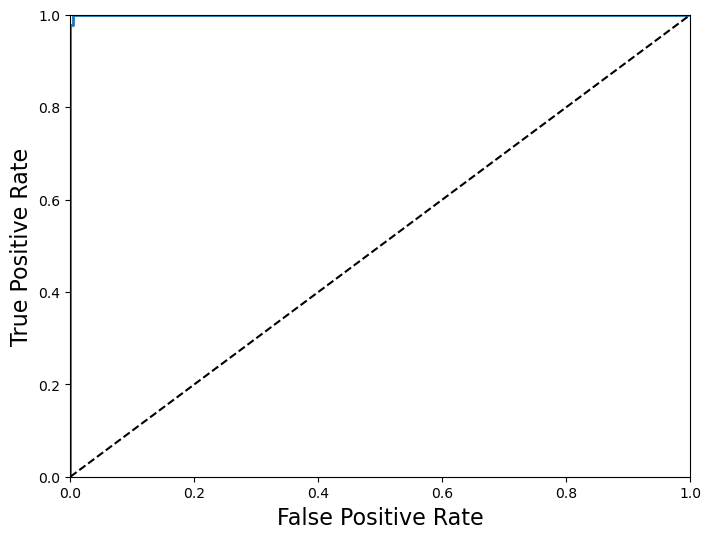

In [91]:
from sklearn.metrics import roc_curve


y_scores = rf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:, 1])

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

In [92]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, y_scores[:, 1])

0.9999138599362564

In [93]:
from sklearn.metrics import f1_score

f1_score(y_test, y_pred)

0.9708029197080292

In [94]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

precision_score(y_test, y_pred), recall_score(y_test, y_pred), accuracy_score(y_test, y_pred)

(1.0, 0.9432624113475178, 0.9909297052154195)

In [95]:
# We look for hyperparameters that have the most impact on the model
importances = pd.DataFrame({'feature': X_train.columns, 'importance': rf.feature_importances_})
importances.sort_values(by='importance', ascending=False, inplace=True)

importances.head(10)

,feature,importance
27,MedianWorkingTime,0.108352
0,Age,0.079949
17,TotalWorkingYears,0.065549
11,MonthlyIncome,0.061005
19,YearsAtCompany,0.055650
3,DistanceFromHome,0.051228
21,YearsWithCurrManager,0.046525
14,PercentSalaryHike,0.044066
12,NumCompaniesWorked,0.038773
10,MaritalStatus,0.037046


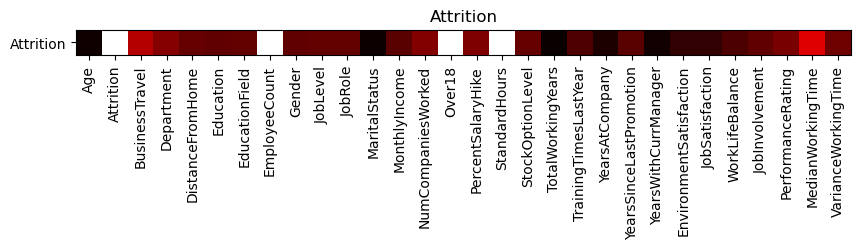

/tmp/nix-shell.b4HYpA/ipykernel_118555/1002696318.py:14: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  for f in importances['feature'][:5]:


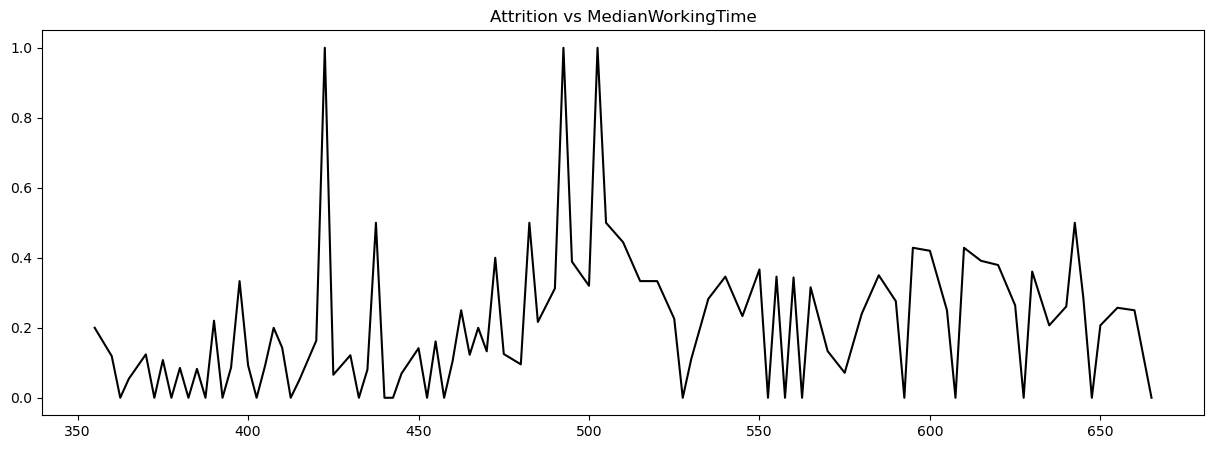

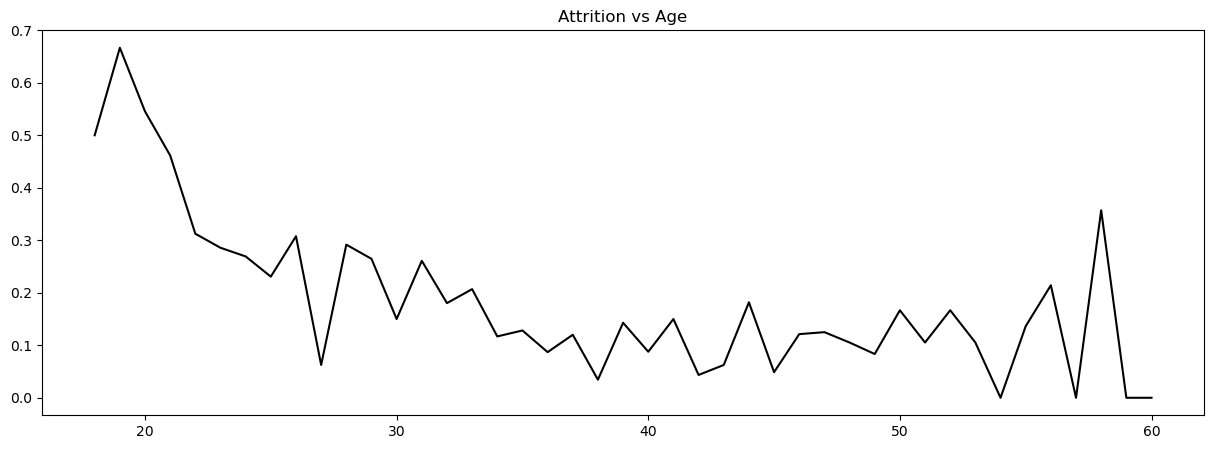

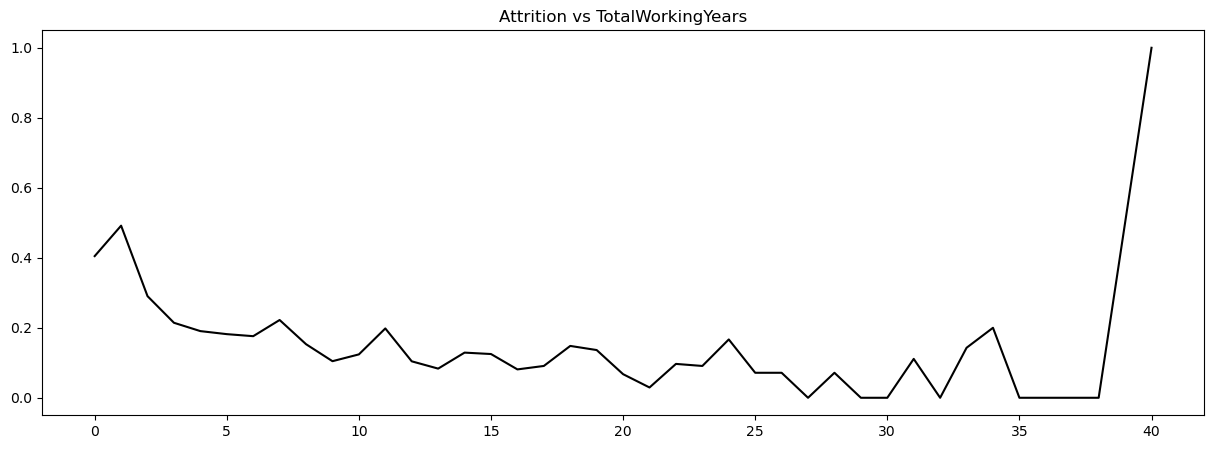

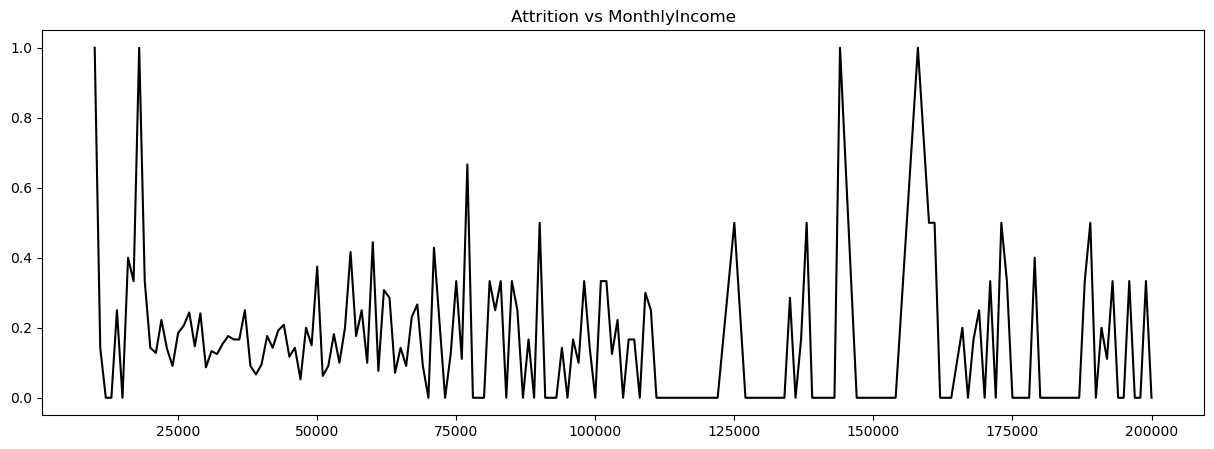

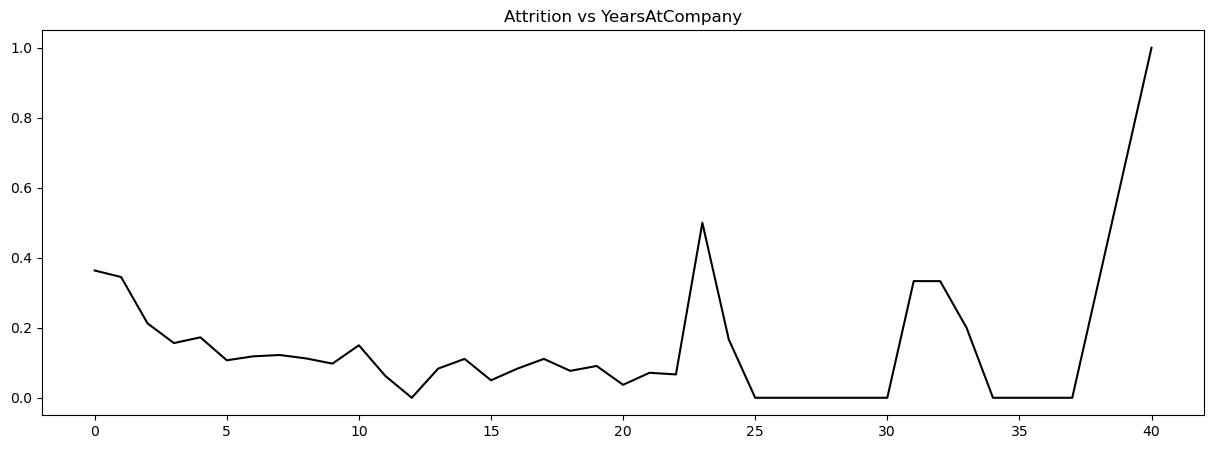

In [99]:
# get correlation matrix
corr = data.corr()

# plot attrition
plt.figure(figsize=(10, 10))
plt.title('Attrition')
plt.imshow(corr['Attrition'].values.reshape(1, -1), cmap='hot', interpolation='nearest')
plt.xticks(range(len(corr['Attrition'])), corr['Attrition'].index, rotation=90)
plt.yticks(range(1), ['Attrition'])

plt.show()

# Plot attrition vs top 5 features
for f in importances['feature'][:5]:
    # Split each age into a group and find out that group's attrition rate
    g = data.groupby(f)['Attrition'].mean()

    # Plot the attrition rate vs age
    plt.figure(figsize=(15, 5))

    plt.title(f'Attrition vs {f}')
    plt.plot(g.index, g.values, 'k-')

    plt.show()